<a href="https://colab.research.google.com/github/dnhshl/cc-ai/blob/main/obstsalat3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ein erstes Beispiel zur Klassifikation von Objekten mit neuronalen Netzen
## Apfel, Orange oder Birne?

Dieses Notebook wurde in Anlehnung an
"Is it a bird? Creating a model from your own data" (https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) von Jeremy Howard,(fast.ai—Making neural nets uncool again, https://www.fast.ai/)
erstellt.

DN 12.03.2023

## Vorbereitendes

aktuellste Version der fast.ai Library und duckduckgo_search Library installieren und weitere Libraries importieren.

In [ ]:
!pip install -Uqq fastai duckduckgo_search
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 11.5 MB/s eta 0:00:00


## Step 1: Daten organisieren.

Hier laden wir Bilder aus dem Internet. Die Bilder finden wir mit Hilfe der Suchmaschine DuckDuckGo

In [ ]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Beispielhaft einige Fotos suchen

In [ ]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('apple fruit photos', max_images=3)
urls

Searching for 'apple photos'


(#3) ['https://images.pexels.com/photos/39803/pexels-photo-39803.jpeg?cs=srgb&dl=food-healthy-apple-39803.jpg&fm=jpg','http://www.onewheaton.com/untold/wp-content/uploads/2015/02/apples2.jpg','https://u.osu.edu/chowline/files/2014/09/57576191-1388yb8.jpg']

...und downloaden

In [ ]:
def download_pictures(urls, path=".", name="image"):
  p = Path(path)
  for i in range(len(urls)):
      filename = f'{name}_{i}.jpg'
      dest = p/filename
      download_url(urls[i], dest, show_progress=False)

In [ ]:
download_pictures(urls, name='apple')

Was haben wir gefunden?

In [ ]:
def show_images(images, path='.'):
  p = Path(path)
  for image in images:
      plt.imshow(Image.open(p/image).to_thumb(256,256))
      plt.title(image)
      plt.show()

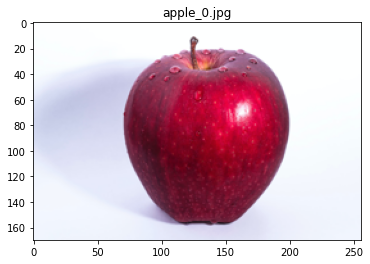

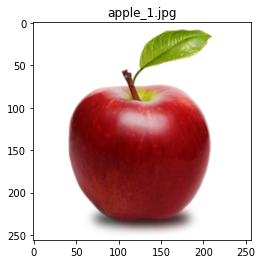

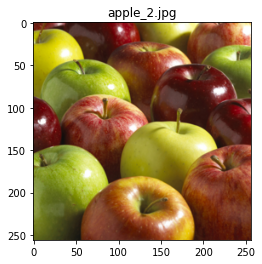

In [ ]:
images = ['apple_' + str(i)+ '.jpg' for i in range(3)]
show_images(images)

Wie sieht es mit Orangen und Birnen aus?

Searching for 'orange fruit photos'


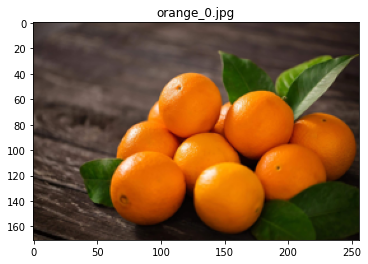

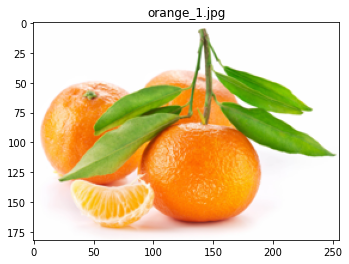

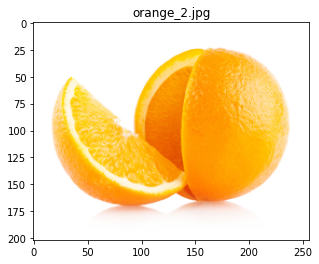

In [ ]:
urls = search_images('orange fruit photos', max_images=3)
download_pictures(urls, name='orange')
images = ['orange_' + str(i)+ '.jpg' for i in range(3)]
show_images(images)

Searching for 'pear fruit photos'


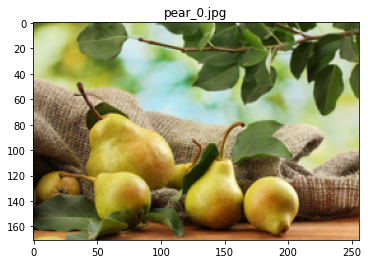

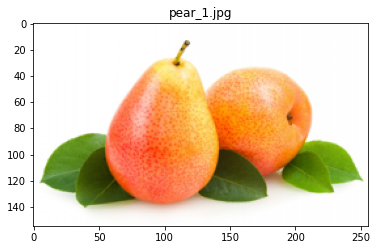

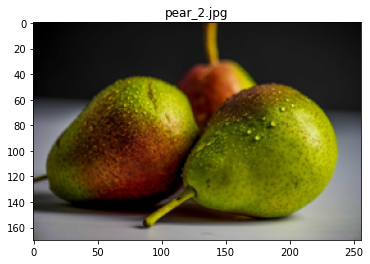

In [ ]:
urls = search_images('pear fruit photos', max_images=3)
download_pictures(urls, name='pear')
images = ['pear_' + str(i)+ '.jpg' for i in range(3)]
show_images(images)

OK, scheint zu funktionieren. Dann laden wir jetzt jeweils 50 Bilder von jeder Sorte, die wir zum Trainieren unseres NN verwenden können.

In [ ]:
classes = 'apple','orange', 'pear'
path = Path('fruits')

for fruit in classes:
    dest = path/fruit
    dest.mkdir(exist_ok=True, parents=True)
    urls = search_images(f'{fruit} fruit photo', max_images=50)
    print(f'downloading {fruit} photos')
    # NB: download_images() ist eine LIbrary Funktion, die parallele Prozesse
    # für den Download anstößt und die Bilder unter einen Zufallsnamen
    # speichert. Das ist besser als unsere download_pictures() Funktion
    download_images(dest, urls=urls)
    print(f'resizing ...')
    resize_images(dest, max_size=400, dest=dest)

downloading apple photos
Searching for 'apple fruit photo'
resizing ...
downloading orange photos
Searching for 'orange fruit photo'
resizing ...
downloading pear photos
Searching for 'pear fruit photo'
resizing ...


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Es ist möglich, dass nicht jeder Download in einem "vernünftigen" Bild (im Sinne von als jpg lesbar) resultiert. Diese "kaputten" Downloads können wir identifizieren und wieder löschen.

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

## Step 2: Das Modell trainieren

Anmerkung: die nachfolgenden Punkte sind eins-zu-eins aus dem fast.ai Notebook übernommen und daher auf Englisch kommentiert.

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

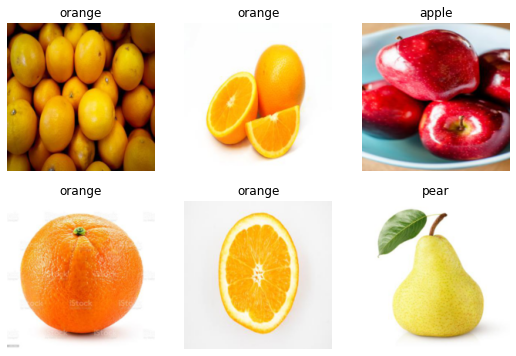

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files,

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.152670,2.037527,0.576923,00:07


epoch,train_loss,valid_loss,error_rate,time
0,1.015482,0.528626,0.192308,00:01
1,0.639289,0.214359,0.076923,00:01
2,0.433708,0.196248,0.115385,00:01


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Das trainierte Modell anwenden

Wir prüfen, wie unser Modell die Beispielbilder klassifiziert, die wir am Anfang geladen haben.

This is a: pear.
Probability it's pear: 0.9994


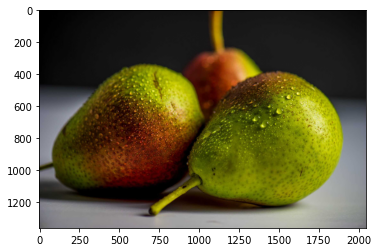

This is a: orange.
Probability it's orange: 0.8964


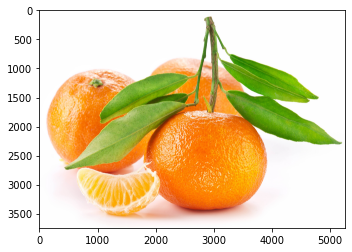

This is a: orange.
Probability it's orange: 1.0000


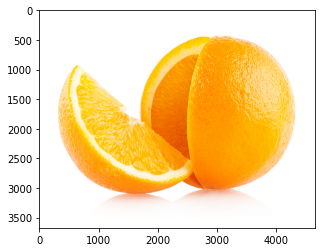

This is a: pear.
Probability it's pear: 1.0000


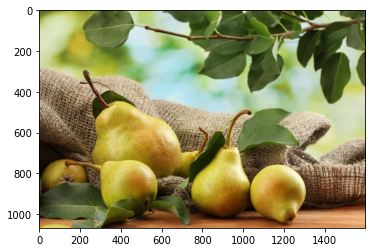

This is a: apple.
Probability it's apple: 0.9996


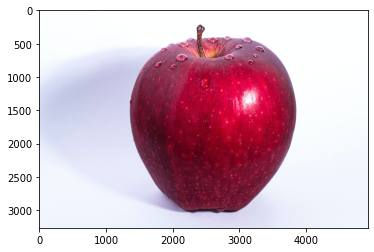

This is a: pear.
Probability it's pear: 0.9991


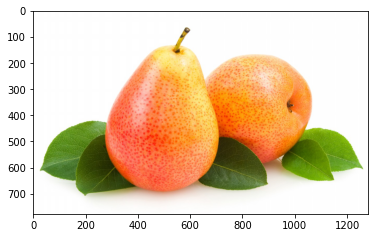

This is a: orange.
Probability it's orange: 0.9798


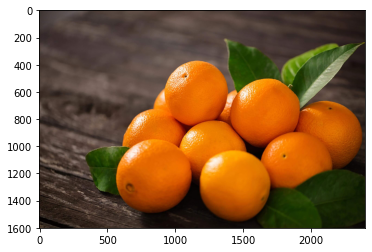

This is a: apple.
Probability it's apple: 0.9989


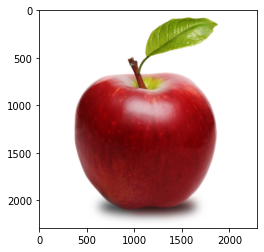

This is a: apple.
Probability it's apple: 0.9760


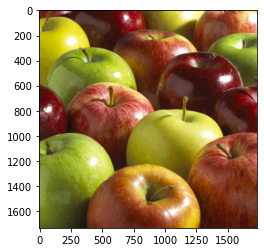

In [ ]:
p = Path('.')
images = p.glob('*.jpg')

for image in images:
    is_fruit,_,probs = learn.predict(image)
    print(f"This is a: {is_fruit}.")
    idx = list(learn.dls.vocab).index(is_fruit)
    print(f"Probability it's {is_fruit}: {probs[idx]:.4f}")
    plt.imshow(Image.open(image))
    plt.show()

Wie gut ist unser Modell insgesamt? Wir prüfen die Konfusionsmatrix für die Validierungsdaten.

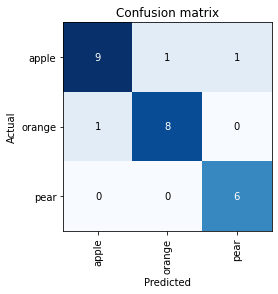

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Step 4: Daten und Modell sichern
### Daten sichern

In [ ]:
!ls .

apple_0.jpg  apple_2.jpg  orange_0.jpg	orange_2.jpg  pear_1.jpg  sample_data
apple_1.jpg  fruits	  orange_1.jpg	pear_0.jpg    pear_2.jpg


In [ ]:
from google.colab import files
!zip -r fruits.zip fruits
files.download('fruits.zip')

  adding: fruits/ (stored 0%)
  adding: fruits/pear/ (stored 0%)
  adding: fruits/pear/b0bc7520-769e-42af-ad3a-f00cbbdfdc8c.jpg (deflated 1%)
  adding: fruits/pear/fb59205b-de3f-49ca-afc8-a6bb4b11f82f.jpg (deflated 1%)
  adding: fruits/pear/4b4bfa33-bc18-4e6d-aac5-d36d591c9a35.jpg (deflated 4%)
  adding: fruits/pear/81722d56-2552-407f-b00e-2538c48fbc21.jpg (deflated 8%)
  adding: fruits/pear/ab1f5b14-548e-4a15-9492-f467d1ed97f8.jpg (deflated 1%)
  adding: fruits/pear/cabc9333-0df4-4e99-853a-f7a191d2e1a4.jpg (deflated 12%)
  adding: fruits/pear/f481b1dd-dc54-4ea5-a49d-6d228c9a5822.jpg (deflated 3%)
  adding: fruits/pear/744a32ab-503a-46ab-bf54-90a2846dcf2c.jpg (deflated 1%)
  adding: fruits/pear/77266d33-f1ec-4a88-aecf-1efec33a244b.jpg (deflated 1%)
  adding: fruits/pear/c473e321-423f-4bf9-b007-d1461547f084.jpg (deflated 1%)
  adding: fruits/pear/0b50db15-653f-4996-9523-e99d99acfbe1.jpg (deflated 1%)
  adding: fruits/pear/264a4eb7-6b34-46f7-a662-c1c7fb2ef040.png (deflated 0%)
  adding: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Modell sichern und downloaden

In [ ]:
learn.export()

In [ ]:
files.download('export.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>